# Monte Carlo control

In [1]:
!pip -q install gym

import numpy as np
import matplotlib.pyplot as plt
import gym
import itertools
from MonteCarlo import *
import copy

In [2]:
env = gym.make('Blackjack-v1', natural=False, sab=False)

## Monte Carlo with exploring starts

In [3]:
player_sum_range = range(32)       
dealer_card_range = range(1, 11)   
usable_ace_range = [True, False]

states = list(itertools.product(player_sum_range, dealer_card_range, usable_ace_range))
actions = [0, 1]

In [9]:
def sample_fn(policy, max_len):
    def sample():
        trajectory = {}
        obs, _ = env.reset()
        for t in range(max_len):
            action = policy(obs)
            obs_, reward, done, info = env.step(action)[:4]
            trajectory[(obs, action)] = reward
            obs = obs_
            if done:
                break
        return trajectory
    return sample

In [21]:
class MonteCarloControl:
    """
    Monte Carlo method for estimating the Q value functions.
    The implementation is similar to the case of value function, except for small twists in the estimate function
    """
    def __init__(self, states, actions):
        """ 
        states: a list of possible states
        actions: a list of possible actions
        """
        self.states = states
        self.actions = actions
        
    def estimate(self, policy, max_iter, gamma=1, every_visit=False):
        """ 
        Estimates the Q value function
        max_iter: number of trajectories used
        gamma: discount factor
        every_visit: Uses every visit Monte Carlo if True, else uses first visit Monte Carlo
        """
        sample = sample_fn(policy, 100)
        value = {state: {action: 0 for action in self.actions} for state in self.states}
        count = {state: {action: 0 for action in self.actions} for state in self.states}
        for i in range(max_iter):
            policy_dict = {state: policy(state) for state in self.states}
            episode = sample()
            cum_reward = 0
            for t, (state_action, reward) in enumerate(list(episode.items())[::-1]):
                state, action = state_action
                t = len(episode) - t - 1
                cum_reward += gamma * reward
                if every_visit or state not in self.states[:t]:
                    count[state][action] += 1
                    value[state][action] = value[state][action] + (cum_reward - value[state][action]) / count[state][action]  
                    policy_dict[state] = max(value[state], key=value[state].get)
            policy = lambda state: policy_dict[state]
        return value, policy

In [22]:
montecarlo = MonteCarloControl(states, actions)
policy = lambda state: 1 if state[0] < 20 else 0
value, optimal_policy = montecarlo.estimate(policy, 100000, True)

In [23]:
true_states = [state for state in states if state[-1] is True]
xy = []
action = []
for state in true_states:
    xy.append(state[:2])
    action.append(optimal_policy(state))
xy = np.array(xy)

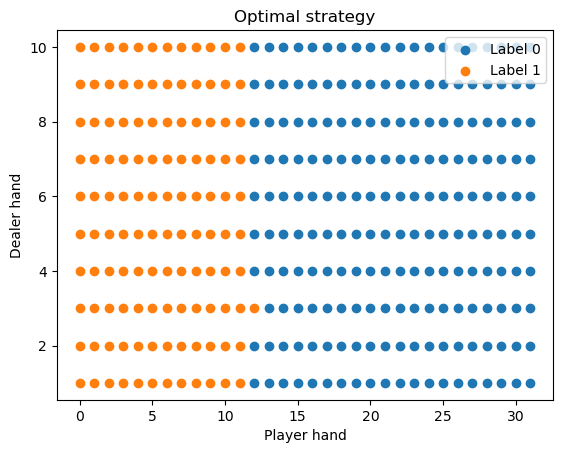

In [24]:
for label in np.unique(action):
    indices = action == label
    plt.scatter(xy[indices, 0], xy[indices, 1], label=f'Label {label}')

plt.xlabel('Player hand')
plt.ylabel('Dealer hand')
plt.title('Optimal strategy')
plt.legend()
plt.show()

## Monte Carlo with stochastic policies

In [28]:
def randomize(policy, actions, epsilon):
    def randomized_policy(state):
        if np.random.randn() < epsilon / len(actions):
            return np.random.choice(actions)
        return policy(state)
    return randomized_policy

In [36]:
class MonteCarloControl:
    """
    Monte Carlo method for estimating the Q value functions.
    The implementation is similar to the case of value function, except for small twists in the estimate function
    """
    def __init__(self, states, actions):
        """ 
        states: a list of possible states
        actions: a list of possible actions
        """
        self.states = states
        self.actions = actions
        
    def estimate(self, policy, max_iter, gamma=1, every_visit=False):
        """ 
        Estimates the Q value function
        max_iter: number of trajectories used
        gamma: discount factor
        every_visit: Uses every visit Monte Carlo if True, else uses first visit Monte Carlo
        """
        sample = sample_fn(policy, 100)
        value = {state: {action: 0 for action in self.actions} for state in self.states}
        count = {state: {action: 0 for action in self.actions} for state in self.states}
        for i in range(max_iter):
            policy_dict = {state: randomize(policy, self.actions, epsilon=0.1)(state) for state in self.states}
            episode = sample()
            cum_reward = 0
            for t, (state_action, reward) in enumerate(list(episode.items())[::-1]):
                state, action = state_action
                t = len(episode) - t - 1
                cum_reward += gamma * reward
                if every_visit or state not in self.states[:t]:
                    count[state][action] += 1
                    value[state][action] = value[state][action] + (cum_reward - value[state][action]) / count[state][action]  
                    policy_dict[state] = max(value[state], key=value[state].get)
            policy = lambda state: policy_dict[state]
        return policy

In [38]:
montecarlo = MonteCarloControl(states, actions)
policy = lambda state: 1 if state[0] < 20 else 0
optimal_policy = montecarlo.estimate(policy, 100000)

In [39]:
true_states = [state for state in states if state[-1] is True]
xy = []
action = []
for state in true_states:
    xy.append(state[:2])
    action.append(optimal_policy(state))
xy = np.array(xy)

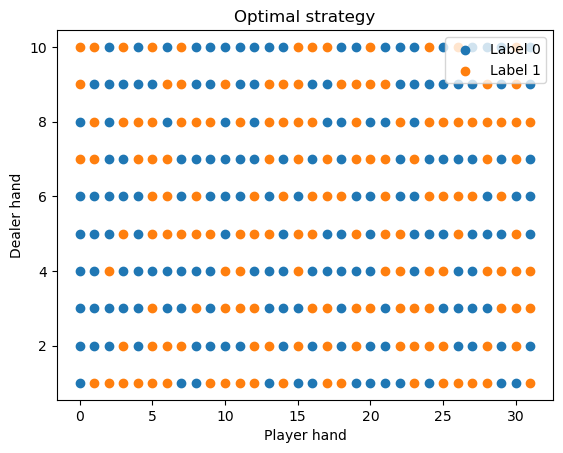

In [40]:
for label in np.unique(action):
    indices = action == label
    plt.scatter(xy[indices, 0], xy[indices, 1], label=f'Label {label}')

plt.xlabel('Player hand')
plt.ylabel('Dealer hand')
plt.title('Optimal strategy')
plt.legend()
plt.show()